<a href="https://colab.research.google.com/github/BagusDAriAwan/creditcard-fraud/blob/master/PAYSIM_kmeans_ifo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import math
import collections
import time
from scipy import stats

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from sklearn.externals.six import StringIO  
import pydotplus

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sb
from sklearn.model_selection import train_test_split, learning_curve

In [0]:
np.random.seed(1)

In [0]:
def confussion_matrik(actual,predict):
    TP,FP,FN,TN = 0,0,0,0
    for i,val in enumerate(actual):
        if val == 0:
            if val == predict[i]:
                TN += 1
            else:
                FP += 1
        if val == 1:
            if val == predict[i]:
                TP += 1
            else:
                FN += 1
    return TP,FP,FN,TN
 
def acc_sens_spec(actual,predict):
    TP,FP,FN,TN = confussion_matrik(actual,predict)
# akurasi
    if (TP+FP+FN+TN) == 0 :
        accuracy = 0 
    else :
        accuracy = (TP+TN)/(TP+FP+FN+TN)
        
# sensitivity
    if (TP+FN) == 0 :
        sensitivity = 0
    else :
        sensitivity = TP/(TP+FN)
        
# specifity    
    if (TN +FP) == 0 :
        specifity = 0
    else :
        specifity = TN/(TN +FP)
        
# precision
    if (TP+FP) == 0 :
        precision = 0
    else :
        precision = TP/(TP+FP)

# recall
    recall = sensitivity

# f1_score
    if (precision+recall) == 0 :
        f1_score = 0
    else :
        f1_score = 2*((precision*recall)/(precision+recall))  
    
    return accuracy,sensitivity,specifity,precision,recall,f1_score

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    #how many correct predictions?
    correct = 0
    #for each actual label
    for i in range(len(actual)):
        #if actual matches predicted label
        if actual[i] == predicted[i]:
            #add 1 to the correct iterator
            correct += 1
    #return percentage of predictions that were correct
    return correct / float(len(actual)) * 100.0

In [0]:
from sklearn.decomposition import PCA
import pylab as pl
def plot_this(X_rs,y_rs,method):
  # Use principal component to condense the 10 features to 2 features
  pca = PCA(n_components=2).fit(X_rs)
  pca_2d = pca.transform(X_rs)
  # Assign colors
  for i in range(0, pca_2d.shape[0]):
    if y_rs[i] == 0:
      c1 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='r', marker='o')
    elif y_rs[i] == 1:
      c2 = pl.scatter(pca_2d[i,0],pca_2d[i,1],c='g', marker='*')  
  pl.legend([c1, c2], ['Class 1', 'Class 2'])
  pl.title(method)
  pl.axis([-4, 5, -4, 4])  # x axis (-4,5), y axis (-4,4)
  pl.show()
    


## ---------

In [0]:
df = pd.read_csv("drive/My Drive/Colab Notebooks/paysim/paysimdata.csv")
df['Class'] = df['isFraud']
df = df.drop(['isFraud'], axis=1)

In [87]:
df.shape

(6362620, 11)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFlaggedFraud    int64
Class             int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [89]:
df['Class'].value_counts()

0    6354407
1       8213
Name: Class, dtype: int64

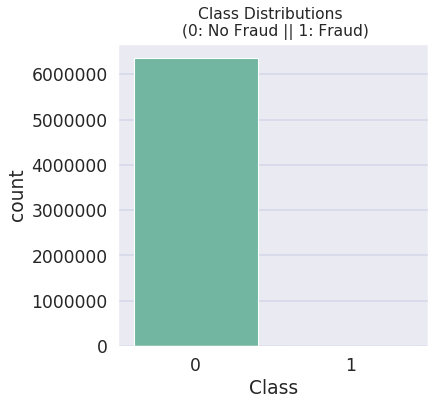

In [90]:
plt.figure(1,figsize=(5, 5), dpi=80)
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
sb.countplot('Class', data=df,palette='Set2')


In [91]:
count = 0
for a in df.columns:
    if df[a].isnull().sum() > 0 :
        print(a)
        count+=1
count

0

In [92]:
len(df.columns)

11

In [93]:
df.head(10)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,Class
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.0,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.0,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.0,0.00,0,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.0,0.00,0,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.0,0.00,0,0
5,1,PAYMENT,7817.71,C90045638,53860.00,46042.29,M573487274,0.0,0.00,0,0
6,1,PAYMENT,7107.77,C154988899,183195.00,176087.23,M408069119,0.0,0.00,0,0
7,1,PAYMENT,7861.64,C1912850431,176087.23,168225.59,M633326333,0.0,0.00,0,0
8,1,PAYMENT,4024.36,C1265012928,2671.00,0.00,M1176932104,0.0,0.00,0,0
9,1,DEBIT,5337.77,C712410124,41720.00,36382.23,C195600860,41898.0,40348.79,0,0


In [0]:
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig',
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [95]:
df.isnull().values.any()

False

----------------------------------

2.1. Which types of transactions are fraudulent?
We find that of the five types of transactions, fraud occurs only in two of them (see also kernels by Net, Philipp Schmidt and Ibe_Noriaki): 'TRANSFER' where money is sent to a customer / fraudster and 'CASH_OUT' where money is sent to a merchant who pays the customer / fraudster in cash. Remarkably, the number of fraudulent TRANSFERs almost equals the number of fraudulent CASH_OUTs (see the right half of the plot in section 5.1). These observations appear, at first, to bear out the description provided on Kaggle for the modus operandi of fraudulent transactions in this dataset, namely, fraud is committed by first transferring out funds to another account which subsequently cashes it out. We will return to this issue later in section 2.4

In [0]:
# print('\n The types of fraudulent transactions are {}'.format(\
# list(df.loc[df.Class == 1].type.drop_duplicates().values))) # only 'CASH_OUT' 
#                                                              # & 'TRANSFER'

# dfFraudTransfer = df.loc[(df.Class == 1) & (df.type == 'TRANSFER')]
# dfFraudCashout = df.loc[(df.Class == 1) & (df.type == 'CASH_OUT')]

# print ('\n The number of fraudulent TRANSFERs = {}'.\
#        format(len(dfFraudTransfer))) # 4097

# print ('\n The number of fraudulent CASH_OUTs = {}'.\
#        format(len(dfFraudCashout))) # 4116

In [97]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [98]:
df['Class'].value_counts()

0    6354407
1       8213
Name: Class, dtype: int64

From the exploratory data analysis (EDA) of section 2, we know that fraud only occurs in 'TRANSFER's and 'CASH_OUT's. So we assemble only the corresponding data in X for analysis

In [99]:
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

randomState = 5
np.random.seed(randomState)

#X = X.loc[np.random.choice(X.index, 100000, replace = False)]

Y = X['Class']
del X['Class']

# Eliminate columns shown to be irrelevant for analysis in the EDA
# X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# Binary-encoding of labelled data in 'type'
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


The data has several transactions with zero balances in the destination account both before and after a non-zero amount is transacted. The fraction of such transactions, where zero likely denotes a missing value, is much larger in fraudulent (50%) compared to genuine transactions (0.06%).

In [100]:
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nThe fraction of genuine transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.4955558261293072

The fraction of genuine transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.0006176245277308345


Since the destination account balances being zero is a strong indicator of fraud, we do not impute the account balance (before the transaction is made) with a statistic or from a distribution with a subsequent adjustment for the amount transacted. Doing so would mask this indicator of fraud and make fraudulent transactions appear genuine. Instead, below we replace the value of 0 with -1 which will be more useful to a suitable machine-learning (ML) algorithm detecting fraud.

In [101]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [102]:
X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
      ['oldBalanceOrig', 'newBalanceOrig']] = -1

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [103]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [0]:
df = X.copy()
df['Class'] = Y.copy()

In [105]:
df['Class'].value_counts()

0    2762196
1       8213
Name: Class, dtype: int64

In [106]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldBalanceOrig',
       'newBalanceOrig', 'nameDest', 'oldBalanceDest', 'newBalanceDest',
       'isFlaggedFraud', 'errorBalanceOrig', 'errorBalanceDest', 'Class'],
      dtype='object')

In [0]:
df_ = df.copy()

In [108]:
df_.tail()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,Class
6362615,743,1,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,0,0.0,0.000000e+00,1
6362616,743,0,6311409.28,C1529008245,6311409.28,0.0,C1881841831,-1.00,-1.00,0,0.0,6.311409e+06,1
6362617,743,1,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,0,0.0,1.000000e-02,1
6362618,743,0,850002.52,C1685995037,850002.52,0.0,C2080388513,-1.00,-1.00,0,0.0,8.500025e+05,1
6362619,743,1,850002.52,C1280323807,850002.52,0.0,C873221189,6510099.11,7360101.63,0,0.0,9.313226e-10,1


In [0]:
# df['type'].unique()

In [0]:
a = {}
i = 1
for m in df_['type'].unique():
  if m not in a :
    a[m] = i
    i +=1
    
df_['type'] = df_['type'].map(a)
# a

In [0]:
a = {}
i = 1
for m in df_['nameOrig'].unique():
  if m not in a :
    a[m] = i
    i +=1
    
df_['nameOrig'] = df_['nameOrig'].map(a)

In [0]:
a = {}
i = 1
for m in df_['nameDest'].unique():
  if m not in a :
    a[m] = i
    i +=1
    
df_['nameDest'] = df_['nameDest'].map(a)

In [113]:
df_.tail()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,Class
6362615,743,2,339682.13,2768626,339682.13,0.0,509563,0.00,339682.13,0,0.0,0.000000e+00,1
6362616,743,1,6311409.28,2768627,6311409.28,0.0,509564,-1.00,-1.00,0,0.0,6.311409e+06,1
6362617,743,2,6311409.28,2768628,6311409.28,0.0,204812,68488.84,6379898.11,0,0.0,1.000000e-02,1
6362618,743,1,850002.52,2768629,850002.52,0.0,509565,-1.00,-1.00,0,0.0,8.500025e+05,1
6362619,743,2,850002.52,2768630,850002.52,0.0,52618,6510099.11,7360101.63,0,0.0,9.313226e-10,1


In [0]:
# # Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
# from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# # RobustScaler is less prone to outliers.

# std_scaler = StandardScaler()
# rob_scaler = RobustScaler()
# minmax_scaler = MinMaxScaler()

# # df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
# # df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# df['scaled_amount'] = minmax_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
# df['scaled_time'] = minmax_scaler.fit_transform(df['Time'].values.reshape(-1,1))

# df.drop(['Time','Amount'], axis=1, inplace=True)

# scaled_amount = df['scaled_amount']
# scaled_time = df['scaled_time']

# df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
# df.insert(0, 'scaled_amount', scaled_amount)
# df.insert(1, 'scaled_time', scaled_time)

# # Amount and Time are Scaled!

# df.head()

In [0]:
X = df_.drop(['Class'], axis=1)
y = df_['Class'].copy()

In [0]:
# X_new = df_new.drop('Class', axis=1)
# y_new = df_new['Class'].copy()

In [0]:
# y_new.value_counts()

In [0]:
# from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

# # RobustScaler is less prone to outliers.

# std_scaler = StandardScaler()
# rob_scaler = RobustScaler()
# minmax_scaler = MinMaxScaler()

# X_neww = minmax_scaler.fit_transform(X_new)
# X_new = pd.DataFrame(X_neww, columns=X_new.columns)
# X_new.tail()

In [119]:
X.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldBalanceOrig',
       'newBalanceOrig', 'nameDest', 'oldBalanceDest', 'newBalanceDest',
       'isFlaggedFraud', 'errorBalanceOrig', 'errorBalanceDest'],
      dtype='object')

In [0]:
from sklearn.preprocessing import Normalizer, MinMaxScaler
scaler = MinMaxScaler()

In [0]:
Xdata = scaler.fit_transform(X)
pca=PCA(n_components=2).fit(Xdata)
pca2d = pca.transform(Xdata)

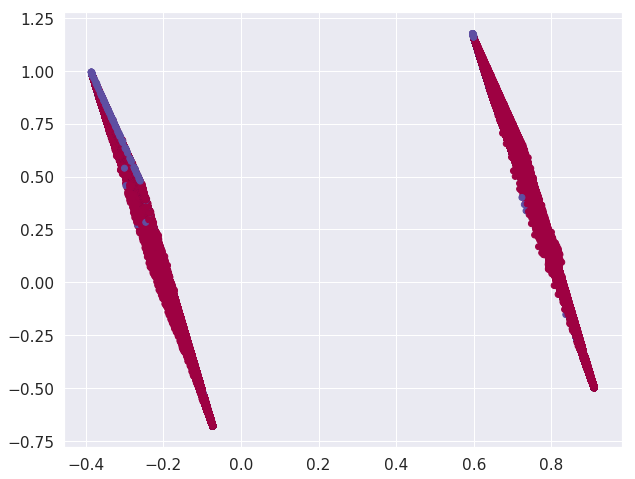

In [122]:
plt.figure(figsize=(10, 8))
plt.scatter(pca2d[:,0], pca2d[:,1], c=y, cmap='Spectral')

## Split Data

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1111, random_state=1, stratify=y_train)


In [125]:
X_train.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest
5520643,380,2,131499.46,2413154,-1.0,-1.0,2300,7552658.53,7684158.00,0,131499.46,-1.000000e-02
1732672,161,1,166186.31,762018,-1.0,-1.0,108042,951079.01,1117265.32,0,166186.31,0.000000e+00
6040663,487,2,111000.58,2634954,-1.0,-1.0,14413,1604936.10,1715936.68,0,111000.58,2.328306e-10
3042360,234,2,144557.75,1335060,49580.0,0.0,10947,260817.97,405375.72,0,94977.75,0.000000e+00
2533668,205,2,194584.08,1112424,26536.0,0.0,204396,505059.00,495973.84,0,168048.08,2.036692e+05


In [0]:
def convert(y):
    for i in range(y.shape[0]):
        if y[i]==-1:
            y[i]=1;
        else:
            y[i]=0
    return y

In [0]:
from sklearn.ensemble import IsolationForest
def iForest(X, ntree, sample, th):
    ifor = IsolationForest(n_estimators=ntree, max_samples=sample, contamination=th, random_state=1)
#     ifor = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.0039, max_features=1.0, random_state=42, verbose=0)
    ifor.fit(X)
    return ifor

In [0]:
def model_evaluate(ifor,X,y):
    ts = time.time()
    y_pred=ifor.predict(X)
    tf = time.time()
    print('time : ', tf-ts)
    y_pred=convert(y_pred)
    
    accuracy,sensitivity,specifity,precision,recall,f1_score = acc_sens_spec(y,y_pred)
    print('accuracy : ',accuracy)
    print('sensitivity : ',sensitivity)
    print('specifity : ', specifity)
    print('precision : ',precision)
    print('recall : ',recall)
    print('f1 score : ',f1_score)
    print('Confusion matrix')
    TP,FP,FN,TN = confussion_matrik(y,y_pred)
    print('TP = ',TP,'FP = ',FP,'FN = ',FN,'TN = ',TN)
    df_cm = pd.DataFrame([[TN,FP],[FN,TP]],
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
    plt.figure(figsize = (8,4))
    sb.set(font_scale=1.4)#for label size
    sb.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

In [0]:
def eval_model(ifor,X,y):
#     ts = time.time()
    y_pred=ifor.predict(X)
#     tf = time.time()
    y_pred=convert(y_pred)
    accuracy,sensitivity,specifity,precision,recall,f1_score = acc_sens_spec(y,y_pred)
    return accuracy,sensitivity,specifity,precision,recall,f1_score

In [0]:
y_test1 = np.array(y_test)
y_train1=np.array(y_train)
y_val1 = np.array(y_val)

In [131]:
print(len(X_train),len(X_val),len(X_test))

2216354 277014 277041


In [132]:
ytrain_ab = y_train[y_train==1]
yval_ab = y_val[y_val==1]
ytest_ab = y_test[y_test==1]
print('fraud train =',len(ytrain_ab),'fraud val =',len(yval_ab),'fraud test =',len(ytest_ab))

fraud train = 6571 fraud val = 821 fraud test = 821


In [133]:
th_train=len(ytrain_ab)/len(y_train)
th_test=len(ytest_ab)/len(y_test)
th_val=len(yval_ab)/len(y_val)
print('threshold train =',th_train, 'threshold test =', th_test,'threshold val =', th_val)

threshold train = 0.002964779092148637 threshold test = 0.002963460282052115 threshold val = 0.002963749124592981


In [134]:
nTree= 100
sample = 256
ifo1 = iForest(X_train, nTree, sample, th_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


time :  8.344815015792847
accuracy :  0.994455153891139
sensitivity :  0.05968331303288672
specifity :  0.9972338183806252
precision :  0.06027060270602706
recall :  0.05968331303288672
f1 score :  0.05997552019583843
Confusion matrix
TP =  49 FP =  764 FN =  772 TN =  275429


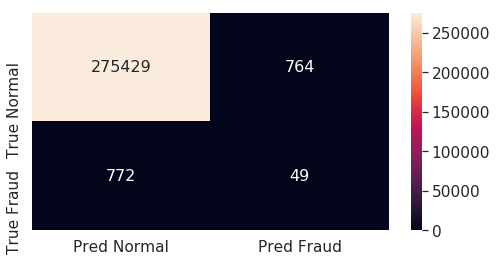

In [135]:
model_evaluate(ifo1,X_val,y_val1)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


time :  8.226388931274414
accuracy :  0.9945531527824402
sensitivity :  0.06090133982947625
specifity :  0.997328216638911
precision :  0.06345177664974619
recall :  0.06090133982947625
f1 score :  0.062150403977625855
Confusion matrix
TP =  50 FP =  738 FN =  771 TN =  275482


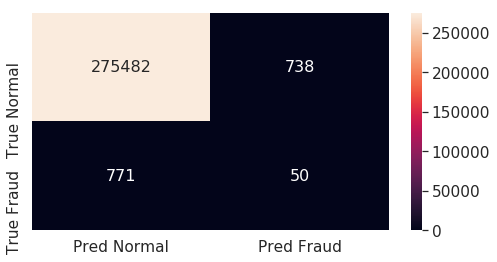

In [136]:
model_evaluate(ifo1, X_test, y_test1)

In [0]:

from sklearn.cluster import KMeans


In [0]:
kmeans_data = scaler.fit_transform(X_train)
pca=PCA(n_components=2).fit(kmeans_data)
pca2dkmeans = pca.transform(kmeans_data)

In [0]:
kmeans_cc = KMeans(n_clusters=2, random_state=1).fit(kmeans_data)

In [0]:
X_kmeans = X_train.copy()
X_kmeans['cluster'] = kmeans_cc.labels_

ytrain_km = y_train.copy()
ytrain_km['cluster'] = kmeans_cc.labels_

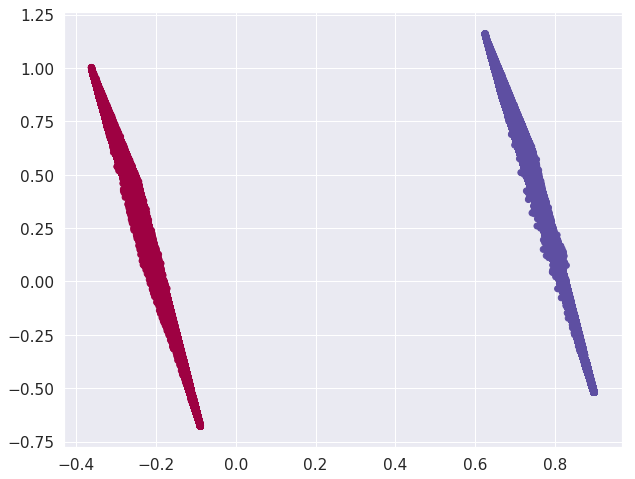

In [141]:
plt.figure(figsize=(10, 8))
plt.scatter(pca2dkmeans[:,0], pca2dkmeans[:,1], c=X_kmeans['cluster'], cmap='Spectral')

In [0]:
clust1 = X_kmeans.loc[X_kmeans['cluster']==0]
y1 = ytrain_km.loc[ytrain_km['cluster']==0]
# y_c1 = y1.drop(['cluster'], axis=1)
clus1=clust1.drop(['cluster'], axis=1)

clust2 = X_kmeans.loc[X_kmeans['cluster']==1]
y2 = ytrain_km.loc[ytrain_km['cluster']==1]
# y_c2 = y2.drop(['cluster'], axis=1)
clus2=clust2.drop(['cluster'], axis=1)

## Cluster 1

In [143]:
len(clus1)

1789859

In [144]:
aby1_train = y1.loc[y1==1]
print('ab train=',len(aby1_train))

ab train= 3272


In [145]:
th1_train= len(aby1_train)/len(y1)
# th1_test= len(aby1_test)/len(X1_test)
print('th train=',th1_train)

th train= 0.0018280769602521763


In [146]:
ifoc1 = iForest(clus1, nTree, sample, th_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


time :  8.247620344161987
accuracy :  0.9848816305313088
sensitivity :  0.2289890377588307
specifity :  0.9871285658941392
precision :  0.05022709056906225
recall :  0.2289890377588307
f1 score :  0.08238387379491675
Confusion matrix
TP =  188 FP =  3555 FN =  633 TN =  272638


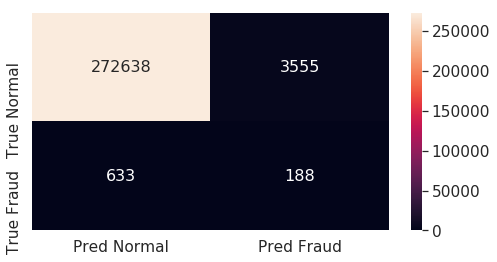

In [147]:
model_evaluate(ifoc1, X_val, y_val1)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


time :  8.408512830734253
accuracy :  0.9850455347764411
sensitivity :  0.23629719853836784
specifity :  0.9872710158569257
precision :  0.0522911051212938
recall :  0.23629719853836784
f1 score :  0.0856323107481792
Confusion matrix
TP =  194 FP =  3516 FN =  627 TN =  272704


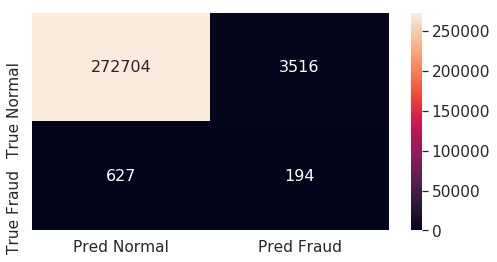

In [148]:
model_evaluate(ifoc1, X_test, y_test1)

## Cluster 2

In [149]:
len(clus2)

426495

In [150]:
aby2_train = y2.loc[y2==1]
# aby2_test = y2_test[y2_test==1]
print('ab train=',len(aby2_train))

ab train= 3299


In [151]:
th2_train= len(aby2_train)/len(clus2)
# th2_test= len(aby2_test)/len(X2_test)
print('th train=',th2_train)

th train= 0.007735143436617077


In [152]:
ifoc2 = iForest(clus2,nTree,sample,th_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


time :  8.118095397949219
accuracy :  0.9965525208112226
sensitivity :  0.023142509135200974
specifity :  0.999446039544811
precision :  0.11046511627906977
recall :  0.023142509135200974
f1 score :  0.038267875125881166
Confusion matrix
TP =  19 FP =  153 FN =  802 TN =  276040


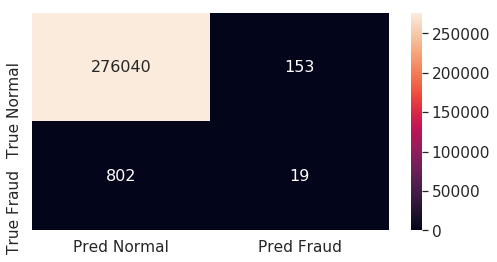

In [153]:
model_evaluate(ifoc2, X_val, y_val1)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


time :  8.03350043296814
accuracy :  0.9965528567973694
sensitivity :  0.014616321559074299
specifity :  0.9994714358120339
precision :  0.0759493670886076
recall :  0.014616321559074299
f1 score :  0.024514811031664963
Confusion matrix
TP =  12 FP =  146 FN =  809 TN =  276074


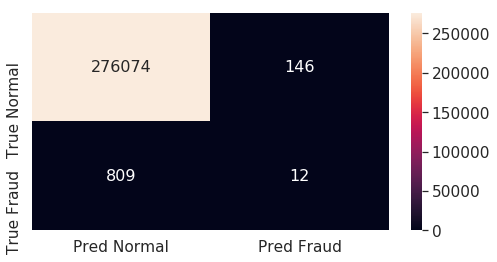

In [154]:
model_evaluate(ifoc2, X_test, y_test)